In [1]:
# ============================================
# Q0. Setup (imports, paths, helpers)
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Models
import lightgbm as lgb
import xgboost as xgb

# Reproducibility
RANDOM_STATE = 42

# Your exact dataset paths
TRAIN_PATH = r"C:\Users\user\Data-Science-main\Titanic_train.csv"
TEST_PATH  = r"C:\Users\user\Data-Science-main\Titanic_test.csv"

print("Train exists:", Path(TRAIN_PATH).exists())
print("Test exists :", Path(TEST_PATH).exists())


Train exists: True
Test exists : True


In [3]:
# ============================================
# Q1.1 Load the Titanic dataset
# ============================================
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
display(train_df.head())


Train shape: (891, 12)
Test shape : (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# ============================================
# Q1.2 Check for missing values
# ============================================
print("Data types:\n", train_df.dtypes)
print("\nMissing values (train):\n", train_df.isnull().sum())

Data types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing values (train):
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


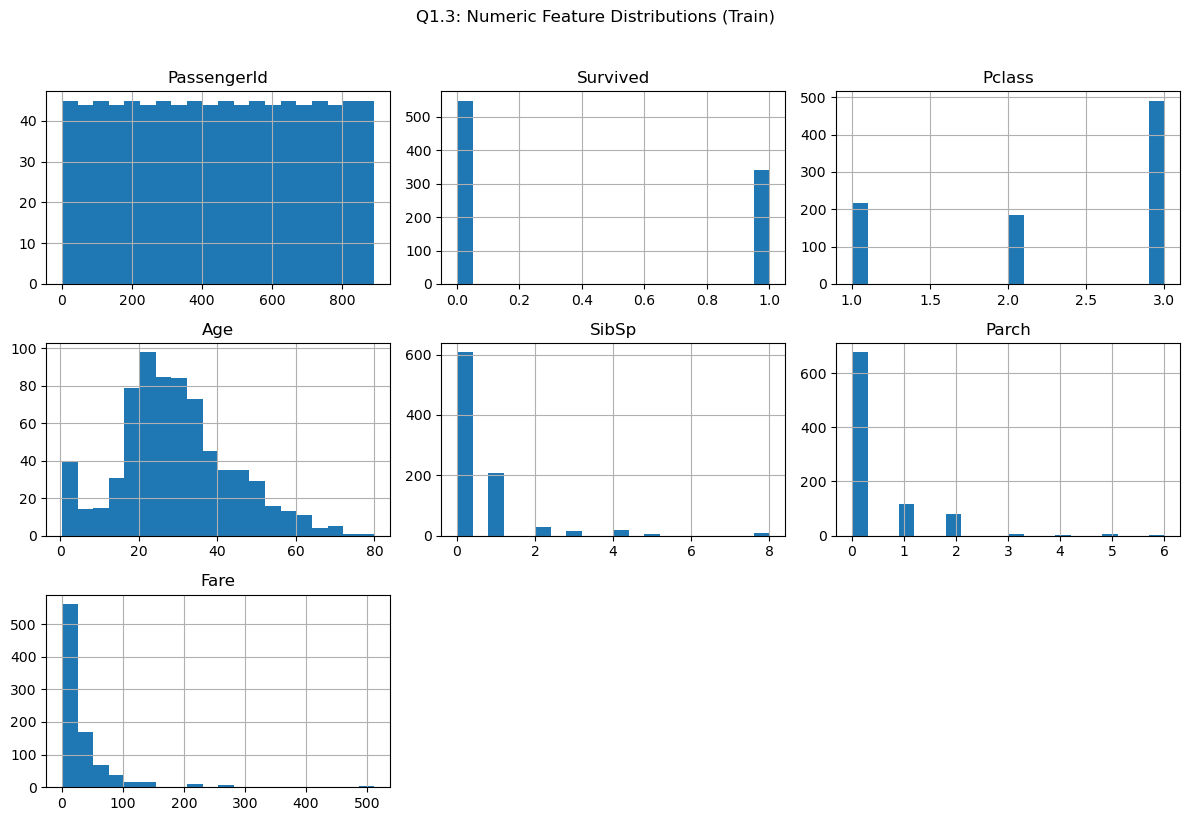

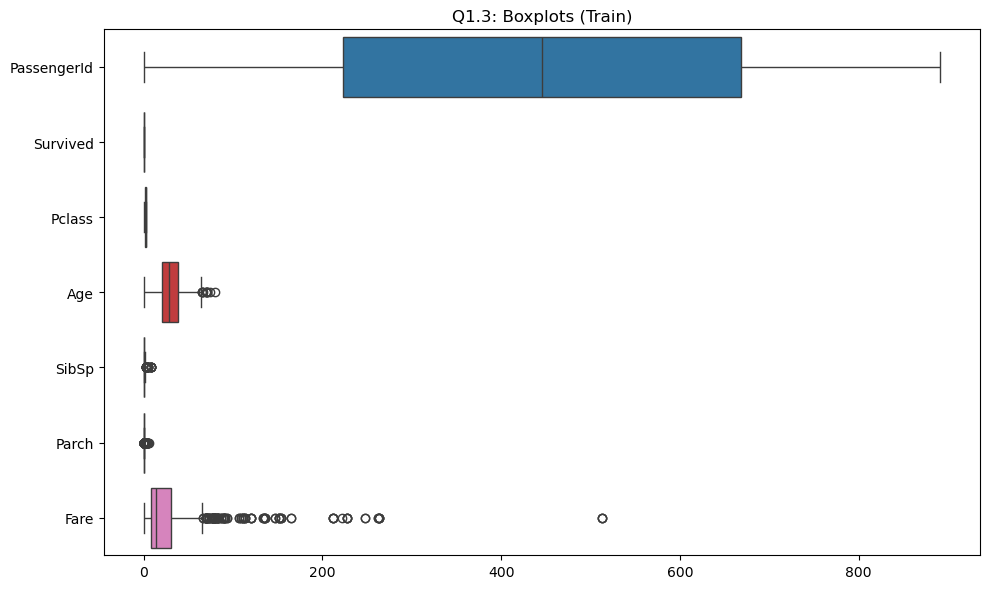

In [7]:
# ============================================
# Q1.3 Explore distributions (histograms & box plots)
# ============================================
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
train_df[num_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle("Q1.3: Numeric Feature Distributions (Train)", y=1.02)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df[num_cols], orient="h")
plt.title("Q1.3: Boxplots (Train)")
plt.tight_layout()
plt.show()


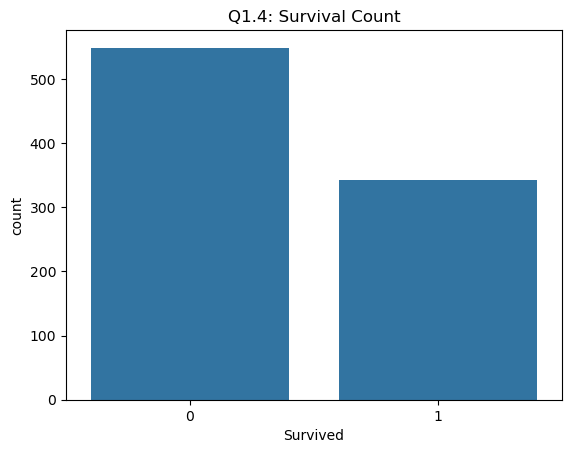

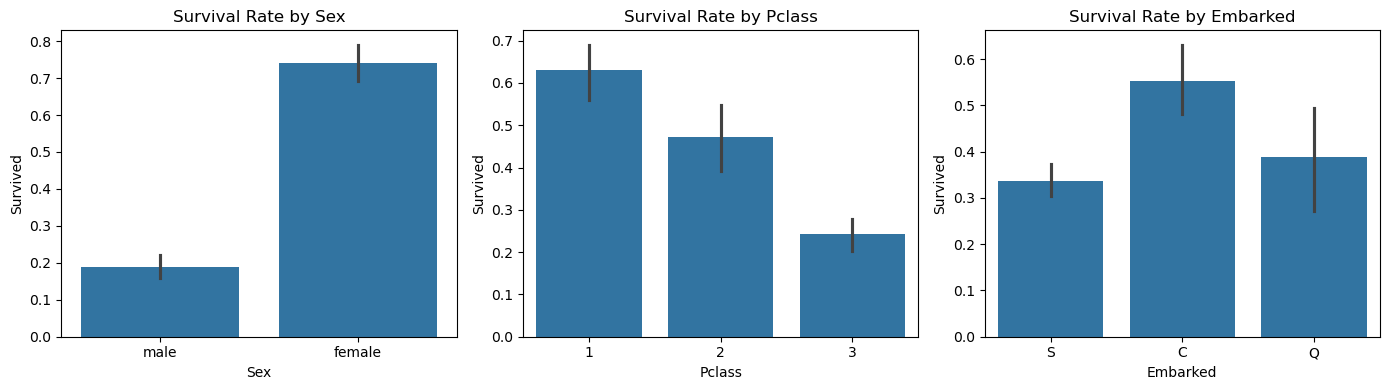

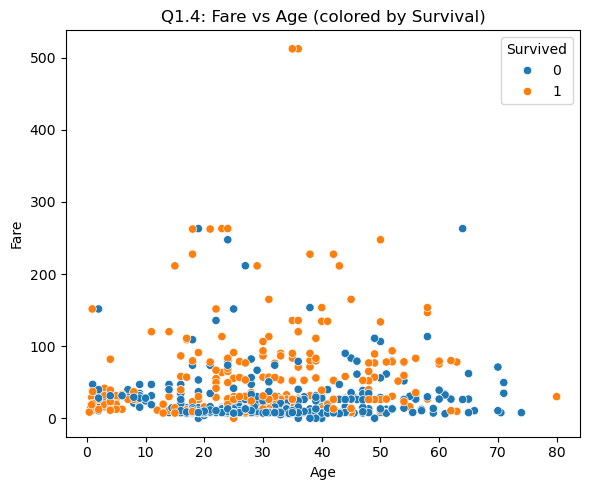

In [9]:
# ============================================
# Q1.4 Visualize relationships (scatter & bar plots)
# ============================================
# Survival distribution
sns.countplot(x='Survived', data=train_df)
plt.title("Q1.4: Survival Count")
plt.show()

# Bar plots for categorical vs survival
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.barplot(x='Sex', y='Survived', data=train_df, ax=axes[0])
axes[0].set_title("Survival Rate by Sex")

sns.barplot(x='Pclass', y='Survived', data=train_df, ax=axes[1])
axes[1].set_title("Survival Rate by Pclass")

sns.barplot(x='Embarked', y='Survived', data=train_df, ax=axes[2])
axes[2].set_title("Survival Rate by Embarked")
plt.tight_layout()
plt.show()

# Scatter: Fare vs Age colored by survival
plt.figure(figsize=(6,5))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_df)
plt.title("Q1.4: Fare vs Age (colored by Survival)")
plt.tight_layout()
plt.show()


In [11]:
# ============================================
# Q2.1 Impute missing values (with simple, sensible rules)
# ============================================
df = train_df.copy()

# Age: impute by median within (Pclass, Sex) groups (more informative than global median)
df['Age'] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda s: s.fillna(s.median()))

# Embarked: most frequent (mode)
if df['Embarked'].isna().any():
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Fare: median (rare in train, common in external test)
if df['Fare'].isna().any():
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

print("Remaining missing (after imputation):\n", df.isnull().sum())


Remaining missing (after imputation):
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [13]:
# ============================================
# Q2.2 Encode categorical variables (one-hot)
# ============================================
# Simple feature engineering to enrich signals:
# - FamilySize, IsAlone
# - Title (extracted from Name)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
title_map = {
    "Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs",
    "Lady":"Rare", "Countess":"Rare", "Capt":"Rare", "Col":"Rare",
    "Don":"Rare", "Dr":"Rare", "Major":"Rare", "Rev":"Rare",
    "Sir":"Rare", "Jonkheer":"Rare", "Dona":"Rare"
}
df['Title'] = df['Title'].replace(title_map)

# Drop high-cardinality / weak features for tree boosters
drop_cols = ['PassengerId','Name','Ticket','Cabin']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# One-hot encode
cat_cols = ['Sex','Embarked','Title']
df = pd.get_dummies(df, columns=[c for c in cat_cols if c in df.columns], drop_first=True)

print("Encoded columns:", [c for c in df.columns if c not in ['Survived']][:10], "...")
display(df.head())


Encoded columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S'] ...


,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_the Countess
0,0,3,22.0,1,0,7.2500,2,0,True,False,True,False,True,False,False,False
1,1,1,38.0,1,0,71.2833,2,0,False,False,False,False,False,True,False,False
2,1,3,26.0,0,0,7.9250,1,1,False,False,True,True,False,False,False,False
3,1,1,35.0,1,0,53.1000,2,0,False,False,True,False,False,True,False,False
4,0,3,35.0,0,0,8.0500,1,1,True,False,True,False,True,False,False,False


In [15]:
# ============================================
# Q2.3 (Optional) Additional preprocessing if needed
# - Tree models (LGBM/XGB) don't require feature scaling.
# - We already imputed, engineered, and one-hot encoded.
# ============================================
pass


In [17]:
# ============================================
# Q3.1 Split into training and testing sets (from preprocessed train)
# ============================================
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (712, 15) Val: (179, 15)


In [24]:
# ============================================
# Q3.2 Choose evaluation metrics
# We'll report Accuracy, Precision, Recall, F1.
# ============================================
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return acc, prec, rec, f1


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

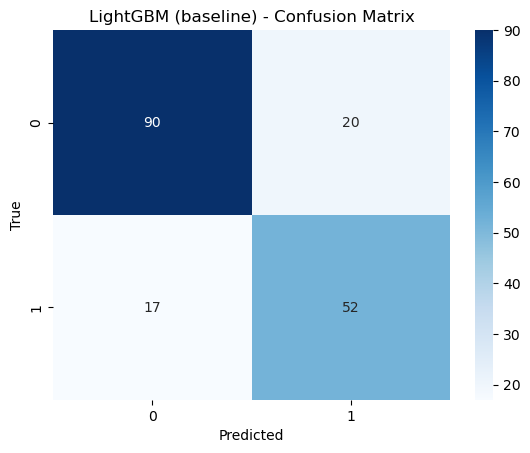


=== XGBoost (baseline) ===
Accuracy : 0.8156
Precision: 0.7812
Recall   : 0.7246
F1-score : 0.7519

Classification Report:
              precision    recall  f1-score   support

           0     0.8348    0.8727    0.8533       110
           1     0.7812    0.7246    0.7519        69

    accuracy                         0.8156       179
   macro avg     0.8080    0.7987    0.8026       179
weighted avg     0.8141    0.8156    0.8142       179



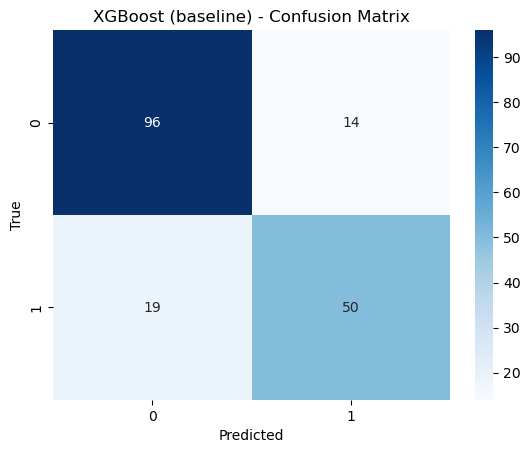

In [21]:
# ============================================
# Q3.3 & Q3.4 Build and train baseline models: LightGBM & XGBoost
# ============================================
# LightGBM baseline
lgb_clf = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8
)
lgb_clf.fit(X_train, y_train)
y_pred_lgb = lgb_clf.predict(X_val)
lgb_scores = evaluate_model(y_val, y_pred_lgb, "LightGBM (baseline)")

# XGBoost baseline
xgb_clf = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist'
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_val)
xgb_scores = evaluate_model(y_val, y_pred_xgb, "XGBoost (baseline)")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

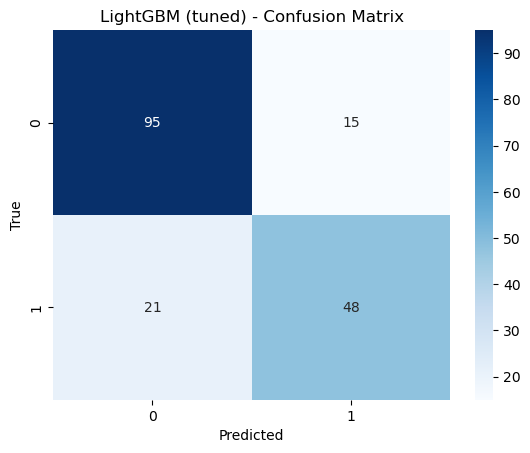

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB params: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

=== XGBoost (tuned) ===
Accuracy : 0.8212
Precision: 0.7846
Recall   : 0.7391
F1-score : 0.7612

Classification Report:
              precision    recall  f1-score   support

           0     0.8421    0.8727    0.8571       110
           1     0.7846    0.7391    0.7612        69

    accuracy                         0.8212       179
   macro avg     0.8134    0.8059    0.8092       179
weighted avg     0.8199    0.8212    0.8202       179



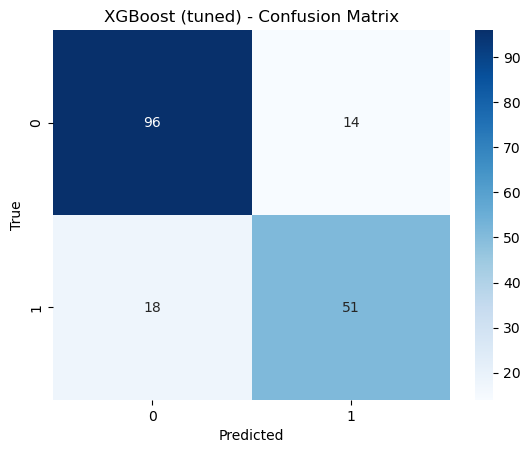

In [23]:
# ============================================
# Q3.5 Cross-validation + hyperparameter tuning (RandomizedSearchCV)
# ============================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# LightGBM search space
lgb_param_dist = {
    "n_estimators": [300, 500, 800, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 4, 6, 8],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
lgb_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=RANDOM_STATE),
    param_distributions=lgb_param_dist,
    n_iter=20,
    scoring="f1",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
lgb_search.fit(X_train, y_train)
best_lgb = lgb_search.best_estimator_
print("Best LGB params:", lgb_search.best_params_)
y_pred_lgb_tuned = best_lgb.predict(X_val)
lgb_tuned_scores = evaluate_model(y_val, y_pred_lgb_tuned, "LightGBM (tuned)")

# XGBoost search space
xgb_param_dist = {
    "n_estimators": [300, 500, 800, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}
xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', tree_method='hist'),
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="f1",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGB params:", xgb_search.best_params_)
y_pred_xgb_tuned = best_xgb.predict(X_val)
xgb_tuned_scores = evaluate_model(y_val, y_pred_xgb_tuned, "XGBoost (tuned)")



=== Q4: Model Performance Comparison ===
                 Model  Accuracy  Precision    Recall        F1
0  LightGBM (baseline)  0.793296   0.722222  0.753623  0.737589
1   XGBoost (baseline)  0.815642   0.781250  0.724638  0.751880
2     LightGBM (tuned)  0.798883   0.761905  0.695652  0.727273
3      XGBoost (tuned)  0.821229   0.784615  0.739130  0.761194


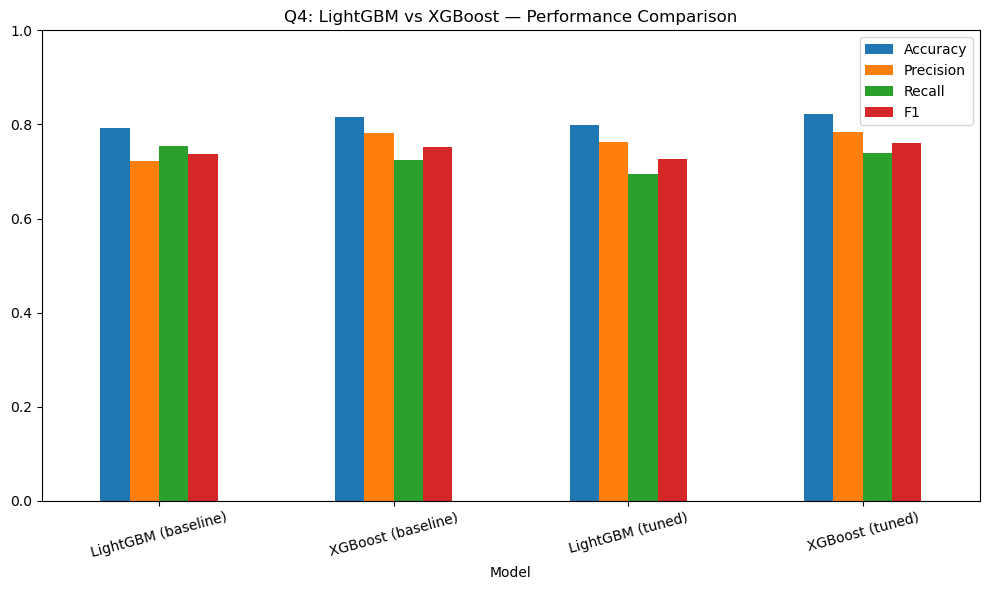

In [25]:
# ============================================
# Q4.1 & Q4.2 Comparative analysis: table + chart
# ============================================
rows = [
    ("LightGBM (baseline)",) + lgb_scores,
    ("XGBoost (baseline)",)  + xgb_scores,
    ("LightGBM (tuned)",)    + lgb_tuned_scores,
    ("XGBoost (tuned)",)     + xgb_tuned_scores,
]
results_df = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1"])
print("\n=== Q4: Model Performance Comparison ===")
print(results_df)

ax = results_df.set_index("Model")[["Accuracy","Precision","Recall","F1"]].plot(
    kind="bar", figsize=(10,6), ylim=(0,1), title="Q4: LightGBM vs XGBoost — Performance Comparison"
)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [31]:
# ============================================
# Q5. (Optional) Apply same preprocessing to your external test set
#     to generate predictions (e.g., for Kaggle submissions)
# ============================================
def preprocess_like_train(raw_df: pd.DataFrame) -> pd.DataFrame:
    df2 = raw_df.copy()

    # Impute
    df2['Age'] = df2.groupby(['Pclass','Sex'])['Age'].transform(lambda s: s.fillna(s.median())) if 'Age' in df2 else df2
    if 'Embarked' in df2:
        df2['Embarked'] = df2['Embarked'].fillna(df2['Embarked'].mode()[0])
    if 'Fare' in df2:
        df2['Fare'] = df2['Fare'].fillna(df2['Fare'].median())

    # FE
    df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
    df2['IsAlone'] = (df2['FamilySize'] == 1).astype(int)
    df2['Title'] = df2['Name'].str.extract(r',\s*([^\.]+)\.')
    df2['Title'] = df2['Title'].replace({
        "Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs",
        "Lady":"Rare", "Countess":"Rare", "Capt":"Rare", "Col":"Rare",
        "Don":"Rare", "Dr":"Rare", "Major":"Rare", "Rev":"Rare",
        "Sir":"Rare", "Jonkheer":"Rare", "Dona":"Rare"
    })

    # Drop
    drop_cols2 = ['PassengerId','Name','Ticket','Cabin']
    df2 = df2.drop(columns=[c for c in drop_cols2 if c in df2.columns])

    # OHE
    df2 = pd.get_dummies(df2, columns=[c for c in ['Sex','Embarked','Title'] if c in df2.columns], drop_first=True)

    # Align to training features
    missing_cols = set(X.columns) - set(df2.columns)
    for c in missing_cols:
        df2[c] = 0
    df2 = df2[X.columns]  # order match
    return df2

test_processed = preprocess_like_train(test_df)
# Example: choose tuned best model for predictions
# final_preds = best_xgb.predict(test_processed)
# pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": final_preds}).head()
